In [6]:
import os       
import cv2       
import numpy as np  
import glob      # tim file
from PIL import Image  #xu ly anh
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import SGD
import shutil

In [7]:
def augment_image(img):
    flip_img = cv2.flip(img, 1)  
    rotate_img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)  
    noise = np.random.normal(0, 25, img.shape).astype(np.int16)  # Gaussian noise
    noisy_img = np.clip(img.astype(np.int16) + noise, 0, 255).astype(np.uint8) 
    return [flip_img, rotate_img, noisy_img]

def augment_dataset(input_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    images = glob.glob(os.path.join(input_folder, '*.png'))

    for img_path in images:
        img = cv2.imread(img_path)
        if img is None:
            continue  

        base_name = os.path.basename(img_path).split('.')[0]

        # copy anh goc
        shutil.copy(img_path, os.path.join(output_folder, base_name + '_original.jpg'))

        # Augment and save
        aug_imgs = augment_image(img)
        cv2.imwrite(os.path.join(output_folder, base_name + '_flip.jpg'), aug_imgs[0])
        cv2.imwrite(os.path.join(output_folder, base_name + '_rotate.jpg'), aug_imgs[1])
        cv2.imwrite(os.path.join(output_folder, base_name + '_noise.jpg'), aug_imgs[2])



In [8]:
train_real_folder = 'train/real'
train_fake_folder = 'train/fake'

In [9]:
augmented_real_folder = 'train_augmented/real'
augmented_fake_folder = 'train_augmented/fake'



In [10]:
augment_dataset(train_real_folder, augmented_real_folder)
augment_dataset(train_fake_folder, augmented_fake_folder)

In [11]:
def merge_folders(source_folders, target_folder):
    if not os.path.exists(target_folder):
        os.makedirs(target_folder)

    for source in source_folders:
        for category in ['real', 'fake']:
            source_category_path = os.path.join(source, category)
            target_category_path = os.path.join(target_folder, category)

            if not os.path.exists(target_category_path):
                os.makedirs(target_category_path)

            images = glob.glob(os.path.join(source_category_path, '*.[jp][pn]g'))  # jpg, jpeg, png

            for img_path in images:
                img_name = os.path.basename(img_path)
                target_path = os.path.join(target_category_path, img_name)
                if os.path.exists(target_path):
                    base, ext = os.path.splitext(img_name)
                    new_img_name = f"{base}_copy{ext}"
                    target_path = os.path.join(target_category_path, new_img_name)

                shutil.move(img_path, target_path)

source_folders = ['train', 'train_augmented']
target_folder = 'train_full'

merge_folders(source_folders, target_folder)

In [13]:
def preprocess_data(data_dir, img_size=(64,64)): #data_dir dan toi thu muc goc
    images = []
    labels = []
    categories = ['real','fake']

    for category in categories:
        path = os.path.join(data_dir, category)
        label = 0 if category == 'real' else 1

        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            try:
                img = Image.open(img_path).convert('RGB')  
                img = img.resize(img_size)               
                img = np.array(img) / 255.0                                  
                images.append(img)
                labels.append(label)
            except Exception as e:
                print(f"Can't read:")
    
    images = np.array(images, dtype=np.float32)
    labels = np.array(labels)

    return images, labels

X, y = preprocess_data(r'train_full', img_size=(64, 64))



In [14]:
print("so luong anh real: ", len(os.listdir(r'train_full\real')))
print("so luong anh deepfake: ", len(os.listdir(r'train_full\fake')))


so luong anh real:  28025
so luong anh deepfake:  30140


In [15]:
print(f"Shape X: {X.shape}")
print(f"Shape y: {y.shape}")


Shape X: (58165, 64, 64, 3)
Shape y: (58165,)


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [17]:
print(f"train: {X_train.shape[0]}")
print(f"test: {X_test.shape[0]}")

train: 46532
test: 11633


In [18]:
def create_cnn_model(input_shape):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')  # Binary classification
    ])
    
    optimizer = SGD(learning_rate=0.01, momentum=0.9)  
    model.compile(optimizer=optimizer, 
                loss='binary_crossentropy', 
                metrics=['accuracy'])
    return model

model = create_cnn_model(X_train.shape[1:])
model.summary()


C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 683,329 (2.61 MB)

 Trainable params: 683,329 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/20
1455/1455 ━━━━━━━━━━━━━━━━━━━━ 72s 48ms/step - accuracy: 0.5420 - loss: 0.6853 - val_accuracy: 0.7035 - val_loss: 0.5819
Epoch 2/20
1455/1455 ━━━━━━━━━━━━━━━━━━━━ 64s 44ms/step - accuracy: 0.7156 - loss: 0.5503 - val_accuracy: 0.8054 - val_loss: 0.4085
Epoch 3/20
1455/1455 ━━━━━━━━━━━━━━━━━━━━ 97s 67ms/step - accuracy: 0.8158 - loss: 0.3998 - val_accuracy: 0.8707 - val_loss: 0.2955
Epoch 4/20
1455/1455 ━━━━━━━━━━━━━━━━━━━━ 138s 94ms/step - accuracy: 0.8802 - loss: 0.2780 - val_accuracy: 0.8956 - val_loss: 0.2504
Epoch 5/20
1455/1455 ━━━━━━━━━━━━━━━━━━━━ 141s 96ms/step - accuracy: 0.9115 - loss: 0.2101 - val_accuracy: 0.9369 - val_loss: 0.1639
Epoch 6/20
1455/1455 ━━━━━━━━━━━━━━━━━━━━ 142s 96ms/step - accuracy: 0.9324 - loss: 0.1636 - val_accuracy: 0.9449 - val_loss: 0.1400
Epoch 7/20
1455/1455 ━━━━━━━━━━━━━━━━━━━━ 88s 60ms/step - accuracy: 0.9513 - loss: 0.1220 - val_accuracy: 0.9521 - val_loss: 0.1210
Epoch 8/20
1455/1455 ━━━━━━━━━━━━━━━━━━━━ 60s 41ms/step - accuracy: 0.960

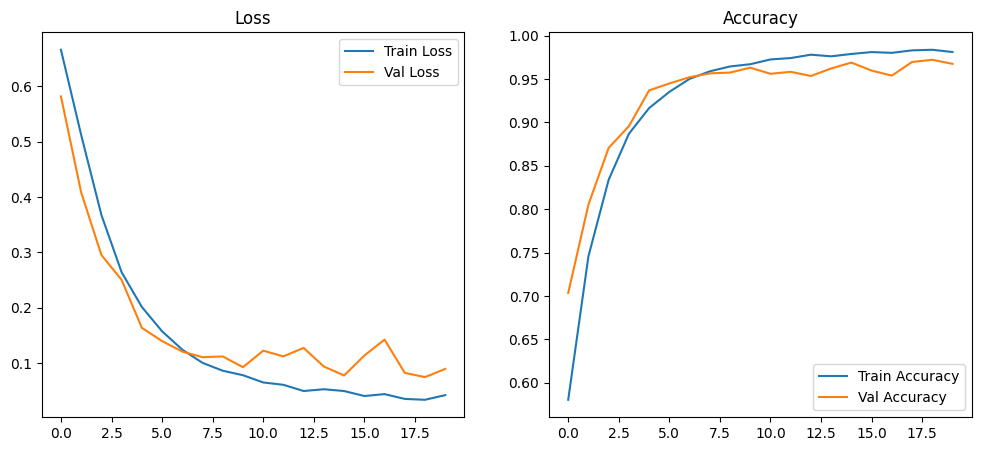

In [20]:
plt.figure(figsize=(12,5 ))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()


In [21]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"test accuracy: {test_acc*100:.2f}%")


364/364 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9669 - loss: 0.0884
test accuracy: 96.75%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


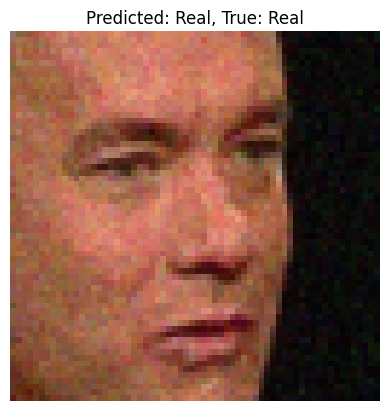

Predicted probability: 0.0000


In [55]:
rand_idx = np.random.randint(0, len(X_test))
x_sample = X_test[rand_idx]
y_true = y_test[rand_idx]

x_input = np.expand_dims(x_sample, axis=0)  # (1, 128, 128, 3) -> batch 1 img
pred = model.predict(x_input)

pred_label = 1 if pred[0][0] >= 0.5 else 0

plt.imshow(x_sample)
plt.axis('off')
plt.title(f"Predicted: {'Fake' if pred_label == 1 else 'Real'}, True: {'Fake' if y_true == 1 else 'Real'}")
plt.show()

print(f"Predicted probability: {pred[0][0]:.4f}")




1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


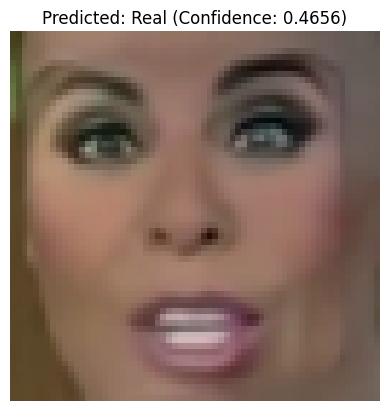

In [61]:
def test_new_img(new_folder, real_or_fake_folder, img_size=(64, 64)):
    real_or_fake_path = os.path.join(new_folder, real_or_fake_folder)
    image_list = os.listdir(real_or_fake_path)

    if len(image_list) == 0:
        raise Exception(f"can't find")

    img_name = np.random.choice(image_list)
    img_path = os.path.join(new_folder,real_or_fake_folder, img_name)

    img = Image.open(img_path).convert('RGB')
    img = img.resize(img_size)
    img_array = np.array(img) / 255.0  
    x_input = np.expand_dims(img_array, axis=0)  # add batch dimension

    return x_input, img_name, img


new_folder = 'test'  
real_or_fake_folder = 'fake'        

x_input, img_name, img_display = test_new_img(new_folder, real_or_fake_folder)

# Predict
pred = model.predict(x_input)
pred_label = 'Fake' if pred[0][0] >= 0.5 else 'Real'

plt.imshow(img_display)
plt.axis('off')
plt.title(f"Predicted: {pred_label} (Confidence: {pred[0][0]:.4f})")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step


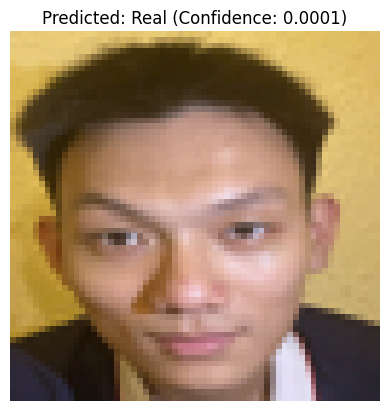

('Real', np.float32(6.6220215e-05))

In [64]:
def pred_new(model, image_path, img_size=(64, 64)):
    img = Image.open(image_path).convert('RGB')
    img = img.resize(img_size)

    #normalize
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  

    # predict
    pred = model.predict(img_array)
    pred_label = 'Fake' if pred[0][0] >= 0.5 else 'Real'

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {pred_label} (Confidence: {pred[0][0]:.4f})")
    plt.show()

    return pred_label, pred[0][0]

pred_new

pred_new(model, r'real.jpg')